<a href="https://colab.research.google.com/github/hugoratruta/RecommendMovie/blob/main/MovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommend Movie

- Objetive: create a movie recommendation;

We are going to use the MovieLens dataset (https://grouplens.org/datasets/movielens/100k/). This dataset contains 100,000 ratings about movies. More about this dataset is founded in it README (https://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

## First Steps -> Reading the dataset

Until today, I never dealt with dataset that did not have a 'showed' extension (for example: 'dataset.csv' or 'dataset.xlsx'). So, when I descompressed the dataset, I have a lot of archives that are describeb on README, but I have not found the format to read the data. Looking on google, I founded that this data is in 'csv' format, so, I will try read this.



In [ ]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from random import sample

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plt_ticker
%matplotlib inline

from sklearn.neighbors import NearestNeighbors

In [ ]:
data = pd.read_csv('/content/u.data')
data.head()

,196\t242\t3\t881250949
0,186\t302\t3\t891717742
1,22\t377\t1\t878887116
2,244\t51\t2\t880606923
3,166\t346\t1\t886397596
4,298\t474\t4\t884182806


Seems to work! But, I need to arrange the data.
The data are separated by '/t' character and don't have a header.
We can use pandas again and add some parameters on 'read_csv' function.

In [ ]:
data = pd.read_csv('/content/u.data', sep='\t', header=None)
data.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Looks better!
Now, I will put the header on dataset.
According to the README: *This is a tab separated list of user id | item id | rating | timestamp*. 
Go to next step!              

In [ ]:
data = pd.read_csv('/content/u.data', sep='\t', header=None)

header = ['user_id', 'item_id', 'rating', 'timestamp']
data.columns = header
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Checking the data type

In [ ]:
data.dtypes

user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object

Great! But 'timestamp' column doesn't make sense.
How this column are *unix seconds since 1/1/1970 UTC* (README.txt), we will convert those data.
Doing this is easy with pandas, using 'to_datetime' function.

In [ ]:
data['date'] = pd.to_datetime(data['timestamp'].astype(int), unit='s')

# dropping 'timestamp' column
data.drop('timestamp', axis=1, inplace=True)

data.head()

,user_id,item_id,rating,date
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


I decided to create 'Year' columns, because I like to see some data by year.

In [ ]:
data['year'] = data['date'].dt.year

Checking info about dataset

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  100000 non-null  int64         
 1   item_id  100000 non-null  int64         
 2   rating   100000 non-null  int64         
 3   date     100000 non-null  datetime64[ns]
 4   year     100000 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 3.8 MB


Converting 'item_id' and 'user_id' to string

In [ ]:
data['user_id'] = data['user_id'].astype(str)
data['item_id'] = data['item_id'].astype(str)

## Descriptive Statistics

In [ ]:
data.describe(include='all')

,user_id,item_id,rating,date,year
count,100000,100000,100000.000000,100000,100000.000000
unique,943,1682,NaN,49282,NaN
top,405,50,NaN,1998-03-27 21:20:06,NaN
freq,737,583,NaN,12,NaN
first,NaN,NaN,NaN,1997-09-20 03:05:10,NaN
last,NaN,NaN,NaN,1998-04-22 23:10:38,NaN
mean,NaN,NaN,3.529860,NaN,1997.471010
std,NaN,NaN,1.125674,NaN,0.499161
min,NaN,NaN,1.000000,NaN,1997.000000
25%,NaN,NaN,3.000000,NaN,1997.000000


So, now I finished my dataset and can go to explore data.

## Adding infos about movies

- Our dataset don't have the movie's title, the genres and other important infos. So, what we need to do is explore the additional data in https://grouplens.org/datasets/movielens/100k/ and add to our dataset.

- An interest data seems to 'u.item' dataset!

In [ ]:
itens = pd.read_csv('/content/u.item', encoding='latin1', on_bad_lines='skip', sep='|', header=None)

The 'itens' dataset looks abstract, so let's go improve it.

Let's correct the header! (see the README)

In [ ]:
header = ["movie id", "movie title", "release date", "video release date",
              "IMDb URL", "unknown", "Action", "Adventure", "Animation",
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
              "Thriller", "War", "Western"]

itens.columns = header
itens.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
itens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie id            1682 non-null   int64  
 1   movie title         1682 non-null   object 
 2   release date        1681 non-null   object 
 3   video release date  0 non-null      float64
 4   IMDb URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children's          1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

I will exclude column 'video release date' (all NaN values) and the column 'IMDB URL, because the IMDb link doesn't matter us now.

In [ ]:
itens.drop(['video release date', 'IMDb URL'], axis=1, inplace=True)

Convert 'release date' to datetime

In [ ]:
itens['release date'] = pd.to_datetime(itens['release date'])

Merging the dataset -> renaming the 'movie id' column from 'itens' dataset

In [ ]:
itens.rename(columns={'movie id':'item_id'}, inplace=True)
itens['item_id'] = itens['item_id'].astype(str)
df = itens.merge(data, how='left')

In [ ]:
df.describe(include='all', datetime_is_numeric=True)

,item_id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_id,rating,date,year
count,100000,100000,99991,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000,100000.000000,100000,100000.000000
unique,1682,1664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,943,NaN,NaN,NaN
top,50,Star Wars (1977),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,405,NaN,NaN,NaN
freq,583,583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,737,NaN,NaN,NaN
mean,NaN,NaN,1988-02-09 00:43:11.369223296,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,...,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540,NaN,3.529860,1997-12-31 00:40:51.488619904,1997.471010
min,NaN,NaN,1922-01-01 00:00:00,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,NaN,1.000000,1997-09-20 03:05:10,1997.000000
25%,NaN,NaN,1986-01-01 00:00:00,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,NaN,3.000000,1997-11-13 19:18:29.500000,1997.000000
50%,NaN,NaN,1994-01-01 00:00:00,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,NaN,4.000000,1997-12-22 21:42:24,1997.000000
75%,NaN,NaN,1996-09-28 00:00:00,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,NaN,4.000000,1998-02-23 18:53:04,1998.000000
max,NaN,NaN,1998-10-23 00:00:00,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,NaN,5.000000,1998-04-22 23:10:38,1998.000000


- **Star Wars (1977)** was the most evaluated movie (583 evaluations);

- The **user_id 405** was one that gave more ratings (737 ratings);

- The mean rating was **3.529860** +/- **1.125674**.


## Exploring dataset

Release year

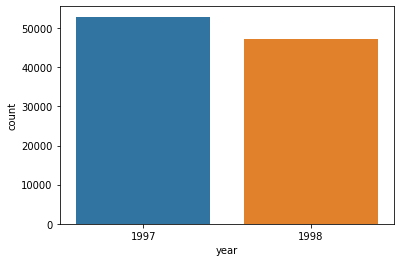

In [ ]:
sns.countplot(data=df, x='year');

Checking the genres

In [ ]:
genres = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

genres_dict = {}
for genre in genres:
 genres_dict[genre] = df.groupby(genre).count()['item_id'][1]

genres_df = pd.DataFrame.from_dict(genres_dict, orient='index', columns=['count']).sort_values(by='count')
genres_df

,count
unknown,10
Documentary,758
Fantasy,1352
Film-Noir,1733
Western,1854
Animation,3605
Musical,4954
Mystery,5245
Horror,5317
Children's,7182


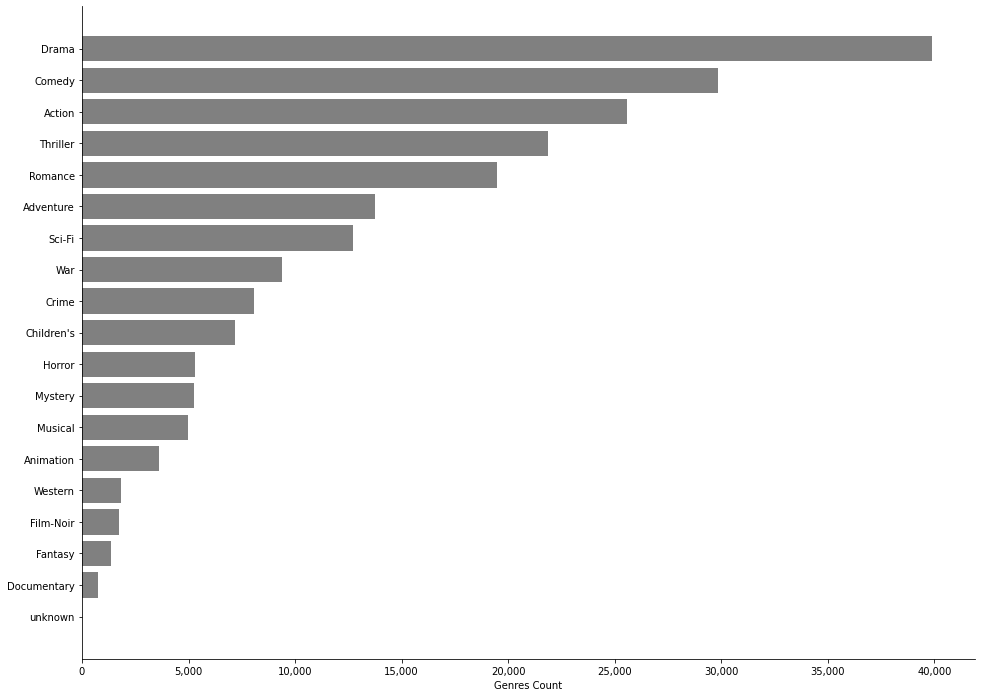

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
plt.rcParams['font.size'] = '16'

ax.get_xaxis().set_major_formatter(plt_ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.barh(y=genres_df.index, width=genres_df['count'], color='gray')
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
ax.set_yticklabels(genres_df.index);
ax.set_xlabel('Genres Count');

Ratings

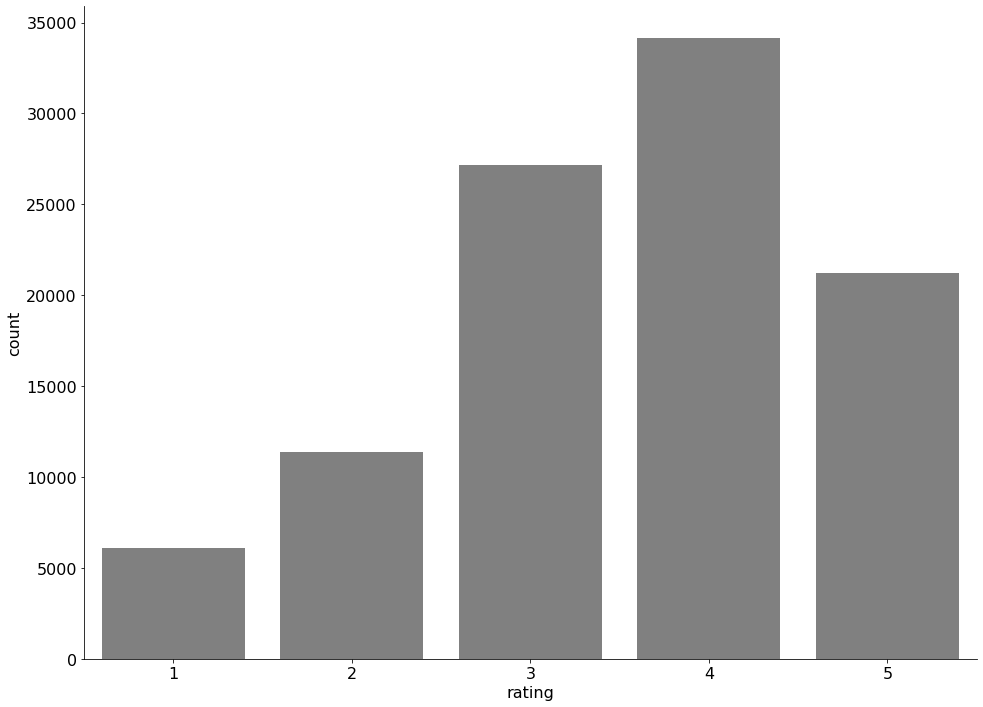

In [ ]:
rating_df = pd.DataFrame(df.groupby('rating').count()['item_id'])
rating_df.rename(columns={'item_id':'count'}, inplace=True)

fig, ax = plt.subplots(figsize=(16,12))
ax.get_xaxis().set_major_formatter(plt_ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax = sns.barplot(x=rating_df.index, y=rating_df['count'], orient='v', color='gray')
ax.set_yticks(np.arange(0,rating_df['count'].max()+5000, 5000))
ax.set_xticklabels(rating_df.index);
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

Ratings by User

In [ ]:
rating_by_user = df.groupby('user_id').count()['rating']
rating_by_user.describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64

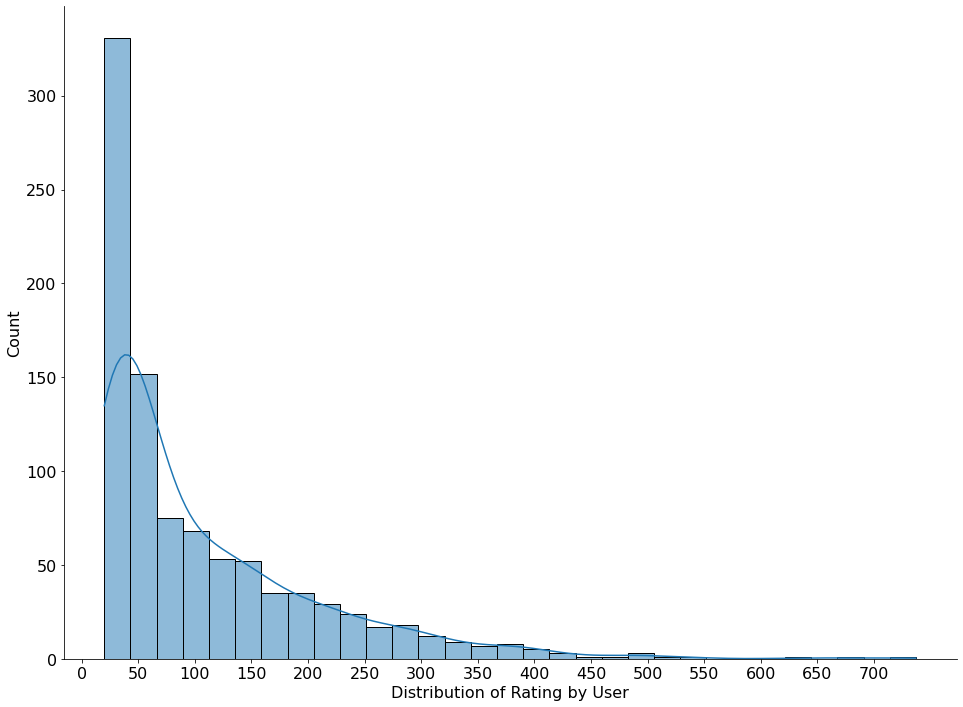

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
ax = sns.histplot(rating_by_user, kde=True)
right_side = ax.spines['right']
right_side.set_visible(False)
top_side = ax.spines['top']
top_side.set_visible(False)
ax.set_xticks(np.arange(0,rating_by_user.max(), 50))
ax.set_xlabel('Distribution of Rating by User');

Rating by movie

In [ ]:
rating_by_movie = df.groupby('movie title').count()
rating_by_movie.sort_values(by='rating', inplace=True, ascending=False)
rating_by_movie.head()

,item_id,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,user_id,rating,date,year
movie title,,,,,,,,,,,,,,,,,,,,,
Star Wars (1977),583,583,583,583,583,583,583,583,583,583,...,583,583,583,583,583,583,583,583,583,583
Contact (1997),509,509,509,509,509,509,509,509,509,509,...,509,509,509,509,509,509,509,509,509,509
Fargo (1996),508,508,508,508,508,508,508,508,508,508,...,508,508,508,508,508,508,508,508,508,508
Return of the Jedi (1983),507,507,507,507,507,507,507,507,507,507,...,507,507,507,507,507,507,507,507,507,507
Liar Liar (1997),485,485,485,485,485,485,485,485,485,485,...,485,485,485,485,485,485,485,485,485,485


In [ ]:
rating_by_movie['rating'].describe()

count    1664.000000
mean       60.096154
std        80.956484
min         1.000000
25%         7.000000
50%        27.000000
75%        80.250000
max       583.000000
Name: rating, dtype: float64

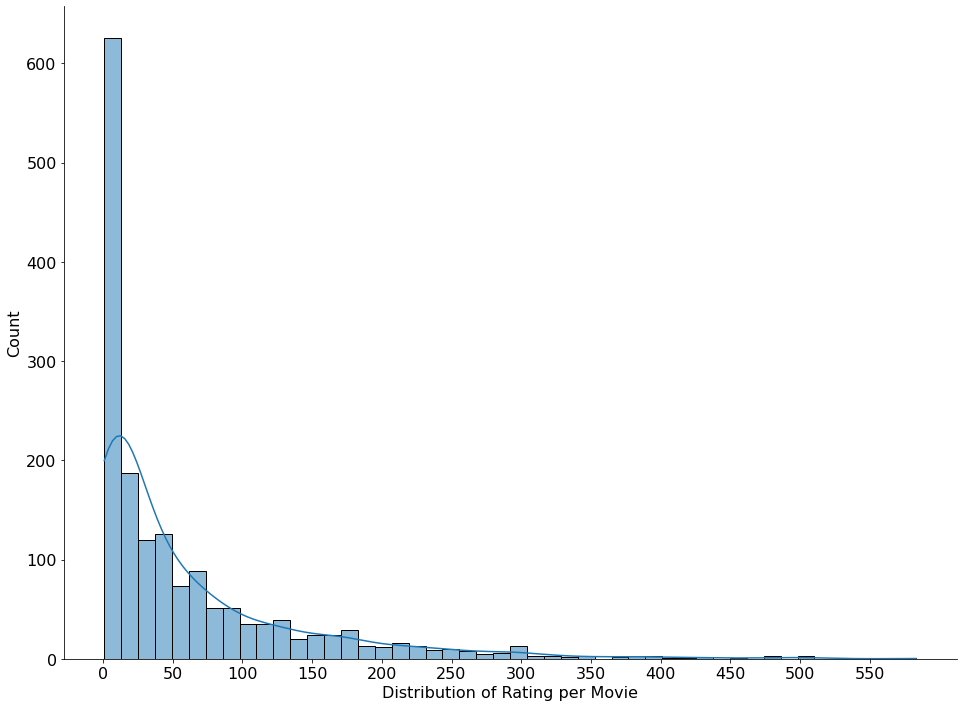

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
ax = sns.histplot(rating_by_movie['rating'], kde=True)
right_side = ax.spines['right']
right_side.set_visible(False)
top_side = ax.spines['top']
top_side.set_visible(False)
ax.set_xticks(np.arange(0,rating_by_movie['rating'].max(), 50))
ax.set_xlabel('Distribution of Rating per Movie');

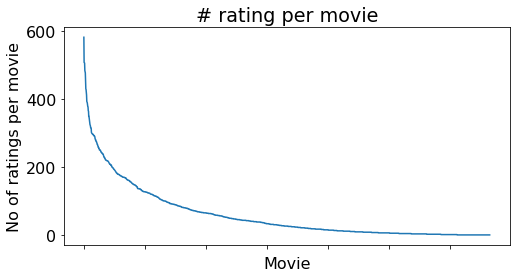

In [ ]:
# Fonte: https://www.kaggle.com/code/saurav9786/recommender-system-using-amazon-reviews/notebook

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(rating_by_movie['rating'].values)
plt.title('# rating per movie')
plt.xlabel('Movie')
plt.ylabel('No of ratings per movie')
ax.set_xticklabels([])

plt.show()

Plotting by ratings

- We can see more ratings in interval [3 - 4]

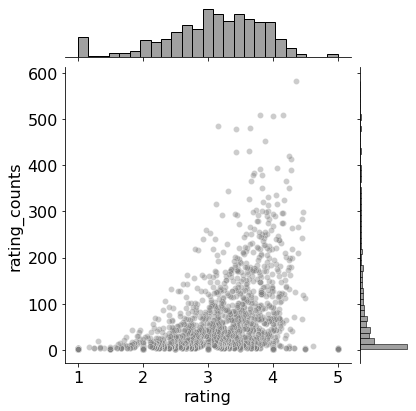

In [ ]:
ratings_df = pd.DataFrame(df.groupby('movie title')['rating'].mean())
ratings_df['rating_counts'] = df.groupby('movie title')['rating'].count()
ratings_df.sort_values(by='rating', ascending=False, inplace=True)

sns.jointplot(x='rating', y='rating_counts', data=ratings_df, alpha=0.4, color='gray')
plt.show()

## Recommending movies by biggest ratings between 4 and 5

In [ ]:
evaluate_rating = df[['movie title', 'rating']]
evaluate_rating = evaluate_rating[evaluate_rating['rating'] >= 4]

movie_rating = {}
for movie in evaluate_rating['movie title'].drop_duplicates():
  movie_rating[movie] = len(evaluate_rating[evaluate_rating['movie title'] == movie])

In [ ]:
movie_rating_df = pd.DataFrame.from_dict(movie_rating, orient='index', columns=['count']).sort_values(by='count', ascending=False)
print(f"Recommended Films -> {list(movie_rating_df.head(10).index)}")

Recommended Films -> ['Star Wars (1977)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Godfather, The (1972)', 'Raiders of the Lost Ark (1981)', 'Silence of the Lambs, The (1991)', 'Contact (1997)', 'Toy Story (1995)', 'English Patient, The (1996)', 'Pulp Fiction (1994)']


## Recommending movies by rating mean and rating counts

In [ ]:
#new_df = df.groupby("movie title").filter(lambda x: x['rating'].count()>= 50)

We will use just movies with more evaluations than Q1 (7 evaluation)

In [ ]:
new_ratings_df = ratings_df[ratings_df['rating_counts'] >= np.percentile(rating_by_movie['item_id'],25)]

## Recommending movies randomly

In [ ]:
print(f'Recommend movies today: {sample(list(new_ratings_df.index),5)}')

Recommend movies today: ['Jumanji (1995)', 'Rosencrantz and Guildenstern Are Dead (1990)', 'Hard Eight (1996)', 'Bridges of Madison County, The (1995)', 'Telling Lies in America (1997)']


## Recommending using kNeighbors

In [ ]:
df['user_id'] = df['user_id'].astype('int')

In [ ]:
movie_user = df.pivot_table(index='user_id',columns='movie title',values='rating')
movie_user.fillna(0,inplace=True)
movie_user.head()

movie title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


Create the model

In [ ]:
knn_model = NearestNeighbors(metric='minkowski')
knn_model.fit(movie_user)

NearestNeighbors()

Reshape the data

In [ ]:
user_index = 100

distance, index_neighbor = knn_model.kneighbors(movie_user.iloc[user_index].values.reshape(1,-1), n_neighbors=6)
index_neighbor

array([[100, 878, 288, 548, 237, 230]])

The movies will be recommended just if the rating was bigger than 4 and each neighbor will give 2 movies

In [ ]:
def recommend_movie(user_index: int):
  user_index = user_index
  distance, index_neighbor = knn_model.kneighbors(movie_user.iloc[user_index].values.reshape(1,-1), n_neighbors=6)
  recommended_movies = []

  for neighbor in index_neighbor.flatten():
    if neighbor == user_index:
      pass
    else:
      c = 0
      for movie in df[(df['user_id'] == neighbor) & (df['rating'] >= 4)]['movie title']:
        recommended_movies.append(movie)
        c += 1
        if c >= 2:        
          break

  if len(recommended_movies) == 10:
    i = 0
    j = 1
    while i < len(recommended_movies):
      j = i + 1
      while j < len(recommended_movies):                
        if recommended_movies[i] == recommended_movies[j]:
          del(recommended_movies[i])                        
          j += 1
        else:
          j += 1  
      i += 1

  while len(recommended_movies) < 10:
    new_df = df[(df['user_id'] == index_neighbor.flatten()[1]) & (df['rating'] >= 4)]
    new_df.set_index(np.arange(len(new_df)), inplace=True)
    num = sample(range(2, new_df.index.max()),1)
    recommended_movies.append(new_df.loc[num]['movie title'])

  return recommended_movies 

In [ ]:
recommend_movie(50)

['Babe (1995)',
 'Richard III (1995)',
 'Mighty Aphrodite (1995)',
 'GoldenEye (1995)',
 'Starship Troopers (1997)',
 'English Patient, The (1996)',
 'Toy Story (1995)',
 'Get Shorty (1995)',
 37    Great Escape, The (1963)
 Name: movie title, dtype: object,
 16    Truth About Cats & Dogs, The (1996)
 Name: movie title, dtype: object]